### Imports

In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 26 11:38:22 2022

@author: lau
"""

#%% IMPORTS

import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

### Sensor estimates/space

In [56]:
#%% PREPROCESSING FUNCTIONS
def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40, # high pass filter
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject="MEG0422", decim=4): # decima = downsampling the data. 4 = 1000Hz -> 250Hz. The higher, the more downsampling.
    
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    
    epochs_list = []

    ######## PATHS ########
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif') # this first section of the for loops just creates the path to the files
        
        print(full_path) # for debugging
        
        ######## RAW FILES AND FILTERING ########
        raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3) 
                    # l_freq=None means we are not applying a low-pass filter
                    # h_freq: high pass filter
                    # n_jobs: number of jobs to run in parallel. -1 means use all processors. It's about processing speed.
        
        ######## FIND EVENTS ########
        # Finding events in the data. min_duration is the minimum duration of the event in seconds.
        events = mne.find_events(raw, min_duration=0.002) 

        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12, # this is a dictionary that maps the event names to the event codes
                            button_press=23)
        elif 'other' in recording_name:
            event_id = dict(other_positive=21, other_negative=22, # this is a dictionary that maps the event names to the event codes
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        
        # Epochs
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim, reject=reject,
                            proj=True) # have proj=True if we want to reject ^
        # epochs object contains the epochs of the raw data
        epochs.pick_types(meg=True) # select only MEG channels
        
        ######## EVOKED - AVERAGE OF EPOCHS ########
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list


In [19]:
# plot timeseries: Here I can plot the timeseries for the first epoch of each of the six recordings by changing the value in []
#epochs_list[1].average().plot() # plot the average of the epochs for the last recording (other_block3)

### Source estimates

In [57]:
# gives the X data that we need for classification
def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    # Here we are just saying that if we don't have a epochs list, run the function above to get it
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    
    # Here we are concatenating event codes for all of the epochs
    ## ... GETTING y (label) ##
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path) # the label is used to specify a label for the source estimate
    else:
        label = None
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    
    ###### GETTING X ########
    for epochs_index, epochs in enumerate(epochs_list): ## get X        

        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        # the forward solution describes the relation between activity of sources and the sensors
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        
        # The noise covariance matrix is an estimate of the covariance
        # in the data, improving the accuracy of  the source estimates.
        # It is computed using the epochs that contain non-task-related
        # activity, i.e. the baseline.
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        
        # inv 
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        # stcs is a list of source estimates for each epoch
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        
        # Concatenates the source estimates for each epoch into one array X
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data # this is the data for the source estimate
            if epochs_index == 0 and stc_index == 0: # if this is the first epoch of the first recording
                n_trials = len(stcs) # then we know how many trials there are
                n_vertices, n_samples = this_data.shape # and we know the shape of the data
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

In [58]:
def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))

    return X, y
    # X contains the data for the source estimates
    # y contains the event codes for the epochs

In [ ]:
#%% RUNNING FUNCTIONS
rawpath = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG"
subjects_dir = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482"

epochs_list = preprocess_sensor_space_data('0111', '20230926_000000',
        raw_path= rawpath,
        decim=10) ##CHANGE TO YOUR PATHS # don't go above decim=10

times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list) # shape= 720, 306, 121: 720 trials, 306 sensors, 121 time points (121 time points because of decim=10)

# reads the sensor space data and do source reconstruction of each the trials. 
#X_source, y = preprocess_source_space_data('0111', '20230926_000000',
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        epochs_list=epochs_list)

 # Source estimates for the left hemisphere Broca's area 44
X_lh_BA44, y = preprocess_source_space_data('0111', '20230926_000000',
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.BA44_exvivo.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.
       

# Source estimates for the left hemisphere primary Visual area (V1)
X_lh_V1, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.V1_exvivo.label', epochs_list=epochs_list)
        

# https://en.wikipedia.org/wiki/Fusiform_gyrus#:~:text=the%20following%20pathways%3A-,Processing%20of%20color%20information,-%5Bedit%5D
# Source estimates for Fusiform Gyrus
X_lh_FG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.fusiform.label', epochs_list=epochs_list)

# sourc eestimates for transverse temporal gyrus (auditory cortex)
## "often associated with the primary auditory cortex"
X_lh_TTG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.transversetemporal.label', epochs_list=epochs_list)

In [ ]:
# seeing number of button presses in each trial
def get_button_presses(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            y = these_epochs.events[:, 2]
        else:
            y = np.concatenate((y, these_epochs.events[:, 2]))

    return y

trial_1_triggers = get_button_presses(epochs_list[4])
print(trial_1_triggers)
#number of button presses in trial 1 (23)
trial_1_triggers[trial_1_triggers == 11].shape

### Simple classification functions

In [33]:
#%% SIMPLE CLASSIFICATION

# Get indicies of the events we want to classify: self positive and self negative or button press
def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

# purpose of equalize_number_of_indices would likely be to
# ensure that you have an equal number of samples for 
# each class or event you want to classify
def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    # trying with support vector machines instead of logistic regression
    from sklearn.svm import svc
    from sklearn.model_selection import GridSearchCV
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


### SVM classication function

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC  # Use SVC for Support Vector Classification

def SVM_classification(X, y, triggers, penalty='none', C=1.0):

    n_samples = X.shape[2]
    indices = get_indices(y, triggers)  # Assuming you have a function get_indices
    X = X[indices, :, :]
    y = y[indices]
    
    sc = StandardScaler()
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    # Define the parameter grid for SVM
    param_grid = {
        'C': [0.1, 1.0, 10.0],          # Regularization parameter
        'kernel': ['linear', 'rbf'],   # Kernel type
        'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
    }
    
    # Create SVM classifier
    svm = SVC(probability=True)
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=cv)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        
        # Fit SVM using GridSearchCV
        grid_search.fit(this_X_std, y)
        
        # Get the best mean score from cross-validation
        best_score = grid_search.best_score_
        
        # Get the best hyperparameters
        best_params = grid_search.best_params_
        
        mean_scores[sample_index] = best_score
        print(f"Sample Index: {sample_index}, Best Mean Score: {best_score}, Best Hyperparameters: {best_params}")
    
    return mean_scores


### Fusiform gyrus

**Self talk**
* <span style="color:red">Self talk negative:</span> 12
* <span style="color:green">Self talk positive:</span> 11
* <span style="color:blue">Button press:</span> 23

**Other talk**
* <span style="color:red">Other talk positive:</span> 21
* <span style="color:green">Other talk negative:</span> 22
* <span style="color:blue">Button press:</span> 23

#### SVM approach

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC  # Use SVC for Support Vector Classification

def SVM_classification(X, y, triggers, penalty='none', C=1.0):

    n_samples = X.shape[2]
    indices = get_indices(y, triggers)  # Assuming you have a function get_indices
    X = X[indices, :, :]
    y = y[indices]
    
    sc = StandardScaler()
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    # Define the parameter grid for SVM
    param_grid = {
        'C': [0.1, 1.0, 10.0],          # Regularization parameter
        'kernel': ['linear', 'rbf'],   # Kernel type
        'gamma': ['scale', 'auto']     # Kernel coefficient for 'rbf'
    }
    
    # Create SVM classifier
    svm = SVC(probability=True)
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=cv)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        
        # Fit SVM using GridSearchCV
        grid_search.fit(this_X_std, y)
        
        # Get the best mean score from cross-validation
        best_score = grid_search.best_score_
        
        # Get the best hyperparameters
        best_params = grid_search.best_params_
        
        mean_scores[sample_index] = best_score
        print(f"Sample Index: {sample_index}, Best Mean Score: {best_score}, Best Hyperparameters: {best_params}")
    
    return mean_scores


In [67]:
# Source estimates for Fusiform Gyrus
X_lh_FG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath,
        subjects_dir=subjects_dir,
        label='lh.fusiform.label', epochs_list=epochs_list)

# Green vs. Red self
sensor_pos_neg_self = simple_classication(X_lh_FG,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

# Green vs blue (response)
sensor_pos_self_response = simple_classication(X_lh_FG,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

# green vs. red other-talk
sensor_pos_neg_other = simple_classication(X_lh_FG,
                                  y, triggers=[22, 21],
                                  penalty='l2', C=1e-3)

# red other talk vs blue response
sensor_neg_self_response_blue = simple_classication(X_lh_FG,
                                  y, triggers=[21, 23],
                                  penalty='l2', C=1e-3)

################ SVM ##################
# red other talk vs blue response
sensor_neg_self_response_blue_SVM = SVM_classification(X_lh_FG,
                                  y, triggers=[21, 23],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_neg_self_response_blue,
                   title="red other talk vs blue response_SVM")
################ SVM ##################

plot_classfication(times, sensor_pos_neg_self,
                   title='green-self vs. red-self')

plot_classfication(times, sensor_pos_self_response,
                   title='green-self vs. blue-response')

plot_classfication(times, sensor_pos_neg_other,
                   title="Green vs red other talk")

plot_classfication(times, sensor_neg_self_response_blue,
                   title="red other talk vs blue response")

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 2.6e-09 (2.2e-16 eps * 306 dim * 3.9e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


### Broca's area 44

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


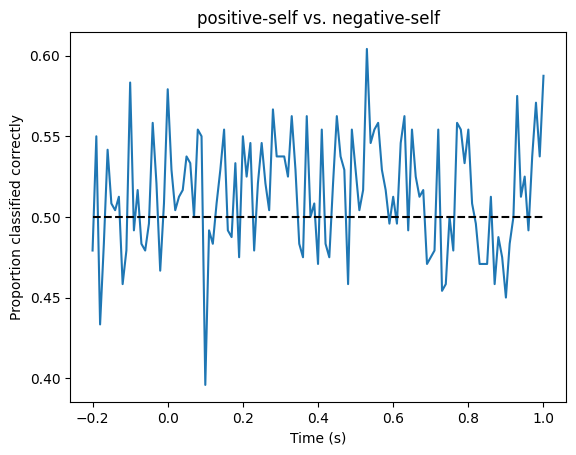

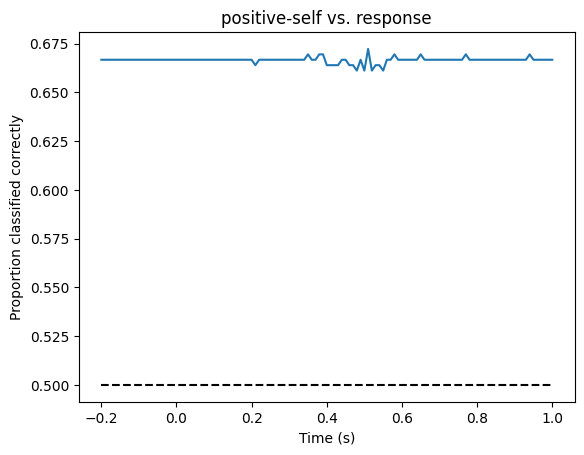

In [43]:
sensor_pos_neg_self_BA44 = simple_classication(X_lh_BA44,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response_BA44 = simple_classication(X_lh_BA44,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

plot_classfication(times, sensor_pos_neg_self_BA44,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response_BA44,
                   title='positive-self vs. response')

### primary Visual area (V1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


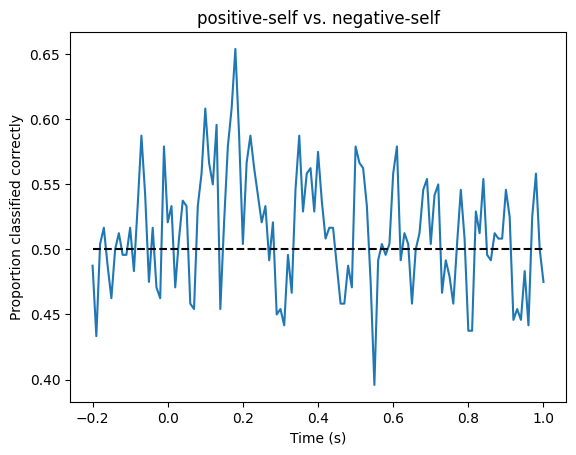

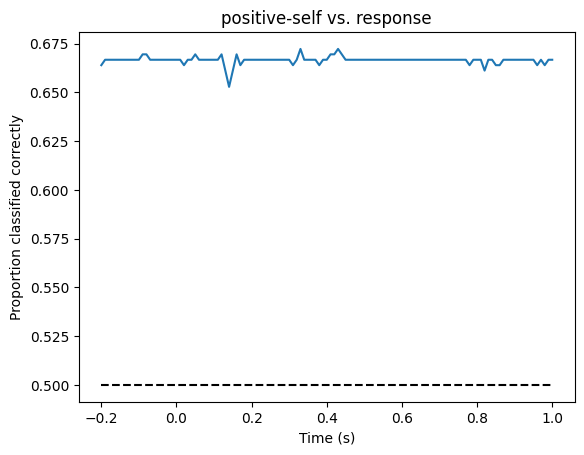

In [42]:
sensor_pos_neg_self_V1 = simple_classication(X_lh_V1,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response_V1 = simple_classication(X_lh_V1,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

plot_classfication(times, sensor_pos_neg_self_V1,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response_V1,
                   title='positive-self vs. response')

### transverse temporal gyrus (auditory cortex)

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 2.6e-09 (2.2e-16 eps * 306 dim * 3.9e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


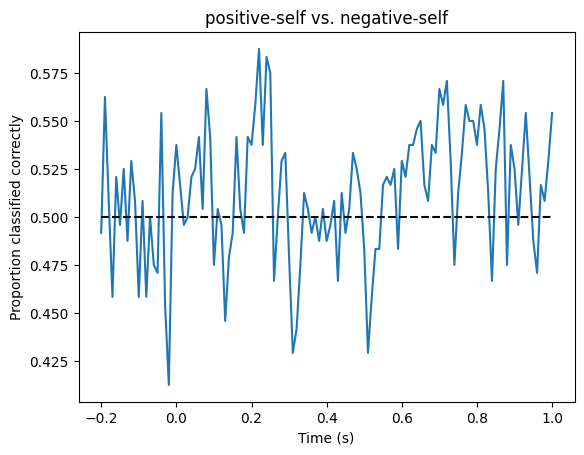

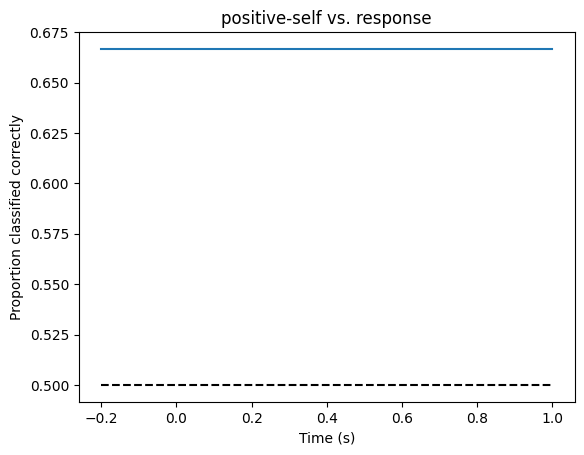

In [60]:
            ##################
############ SOURCE ESTIMATES ############
            ##################
# source eestimates for transverse temporal gyrus (auditory cortex)
## "often associated with the primary auditory cortex"
X_lh_TTG, y = preprocess_source_space_data('0111', '20230926_000000', 
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.transversetemporal.label', epochs_list=epochs_list) # transversetemporal -> auditory cortex

            #################
############# CLASSIFICATION #############
            #################
sensor_pos_neg_self_TTG = simple_classication(X_lh_TTG,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response_TTG = simple_classication(X_lh_TTG,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

plot_classfication(times, sensor_pos_neg_self_TTG,
                   title='positive-self vs. negative-self in the auditory cortex')

plot_classfication(times, sensor_pos_self_response_TTG,
                   title='positive-self vs. response in the auditory cortex')

### Running simple classification

In [ ]:
sensor_pos_neg_self = simple_classication(X_sensor,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

sensor_pos_self_response = simple_classication(X_sensor,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

#%% PLOT
plot_classfication(times, sensor_pos_neg_self,
                   title='positive-self vs. negative-self')

plot_classfication(times, sensor_pos_self_response,
                   title='positive-self vs. response')